# Reading and controlling the board temperature

We have access to the RFSoC chip's internal temperatures through the SYSMON interface, see docs:
* https://docs.amd.com/v/u/en-US/ug580-ultrascale-sysmon
* https://xilinx-wiki.atlassian.net/wiki/spaces/A/pages/18842163/Zynq+UltraScale+MPSoC+AMS

We have limited access to the board's fan controller, all we can do is toggle between "full-speed" mode and automatic control:
* https://docs.amd.com/r/en-US/ug1390-zcu216-eval-bd/Cooling-Fan-Connector

This is still enough for a very crude temperature controller.

To run this code, you will need to install the Python libraries for libgpiod and libiio. If your board has Internet access, this is easy: run `apt install python3-libiio python3-libgpiod` as root.
It's possible to access the kernel interfaces for both without installing anything, but that's less portable between boards and versions of the PYNQ OS image.
This code was written on a ZCU216 running a PYNQ 3.0.1 OS image; for a different board you may need to change device and line names.

In [2]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The temperature reading is pretty noisy - single readings have an RMS of ~0.2 degrees C.
(It's also totally uncalibrated, but that doesn't matter if we just want to stabilize it.)
Averaging over more readings helps.
Most of the noise is at relatively low frequencies, so spacing the readings by 2 ms doesn't hurt much and uses much less CPU than reading as fast as possible.

We'll read the PL temperature (the FPGA side of the chip), which is probably the most relevant.

In [445]:
import time
from tqdm.auto import tqdm
import gpiod
import iio
SAMPS_PER_SEC = 12000 # estimated

def get_channel_value(ch, dt, spacing=0.002):
    """
    dt: duration to average over, in seconds (0 = just take one sample)
    spacing: time between readings, in seconds (0 = take samples as fast as possible, ~12 kHz)
    """
    if dt == 0:
        nsamp = 1
        spacing = 0
    else:
        if spacing == 0:
            nsamp = int(SAMPS_PER_SEC*dt)
        else:
            nsamp = int(dt/spacing)
    if spacing == 0:
        vals = [int(ch.attrs['raw'].value) for i in range(nsamp)]
    else:
        vals = []
        for i in range(nsamp):
            vals.append(int(ch.attrs['raw'].value))
            time.sleep(spacing)
    if 'offset' in ch.attrs:
        return (np.mean(vals)+int(ch.attrs['offset'].value))*float(ch.attrs['scale'].value)/1000
    else:
        return np.mean(vals)*float(ch.attrs['scale'].value)/1000

c = iio.LocalContext()
d = c.find_device('ams')
ch = d.find_channel('pl_temp')

print(get_channel_value(ch, 1.0)) # average over 1 second

50.54075702864995


In [411]:
with gpiod.Chip("/dev/gpiochip2") as chip:
    line = chip.find_line("MAX6643_FULL_SPEED")
    line.request("")
    line.set_direction_output()
    line.set_value(1) # max fan
    time.sleep(1)
    line.set_value(0) # auto fan

We can do a crude PID control. There's probably a better algorithm for this situation, but PID is easy to write.
* Because the fan control is binary, we low-pass filter the fan state (in other words, take an average of the recent fan states) and use that in our control function - this gives a PWM-like effect.
* Because the temperature reading is fairly noisy, we low-pass filter the derivative.
* The integral can diverge badly during transients, particularly the initial transient when we're bringing things under control. We clamp it to stay within a range.

The parameters (the PID factors and the various time constants) are not particularly optimized.

You will want to choose a target temperature below than the equilibrium temperature for your board's environment and your firmware (the FPGA power consumption depends mostly on what firmware you have loaded). The temperature difference between max-fan and auto-fan is ~5 degrees, so you want to be within that range.

You should be able to run this in parallel with firmware changes (to see how it responds to transients) or your real measurements.

In [446]:
duration = 120 # seconds
target = 48.0 # C

data = []

dt = 0.25 # time to average over - seconds
t_deriv = 1.5 # time constant for derivative filter, smaller value speeds up updates but increases noise - seconds
t_integral = 60.0 # time constant for integral filter - seconds
t_fan = 2.0 # time constant for averaging the fan - seconds

# PID parameters, bigger = more aggressive
kp = 3 # 1/C
ki = 100 # 1/C
kd = 20 # sec/C

clamp_integral = 2 # dimensionless

filt_deriv = (1.0-np.exp(-dt/t_deriv))
filt_integral = (1.0-np.exp(-dt/t_integral))
filt_fan = (1.0-np.exp(-dt/t_fan))

fan = -1 # this is -1 for auto, +1 for full-speed
fan_avg = 0
prev = None # previous value, for calculating derivative
integral = 0 # C
deriv = 0 # C/sec
t0 = time.time()
with gpiod.Chip("/dev/gpiochip2") as chip:
    line = chip.find_line("MAX6643_FULL_SPEED")
    line.request("")
    line.set_direction_output()
    for i in tqdm(range(int(duration/dt))):
        t = time.time() - t0
        val = get_channel_value(ch, dt)
        
        prop = val-target
        if prev is None:
            print("initial temperature=%.2f"%(val))
            prev = prop
        diff = (prop-prev)/dt
        prev = prop
        deriv += filt_deriv*(diff-deriv)
        integral += filt_integral*(prop-integral)
        
        integral = np.clip(integral, -clamp_integral/ki, clamp_integral/ki)
        
        control = prop*kp + integral*ki + deriv*kd
        if control > fan_avg:
            fan = 1
            line.set_value(1) # fan at full speed
        elif control < fan_avg:
            fan = -1
            line.set_value(0) # fan at auto
        fan_avg += filt_fan*(fan-fan_avg)

        print("time=%.2f\ttemp=%.2f\tP=% .3f\tI=% .3f\tD=% .3f\tfan=% d"%
              (t, val, prop, integral, deriv, fan), end='\r')
        data.append((t, val, prop, integral, deriv, control, fan, fan_avg))
            
    line.set_value(0) # put fan back on auto when we're done
    
data = np.array(data)

  0%|          | 0/480 [00:00<?, ?it/s]

initial temperature=50.54


It's not perfect (there's usually some residual oscillation at the natural period of a few seconds) but adequate - the temperature will be under control within a minute and will be stabilized to within ~0.1 degree.
You'll hear the controller respond to air currents and changes in airflow (holding your hand over the fan).

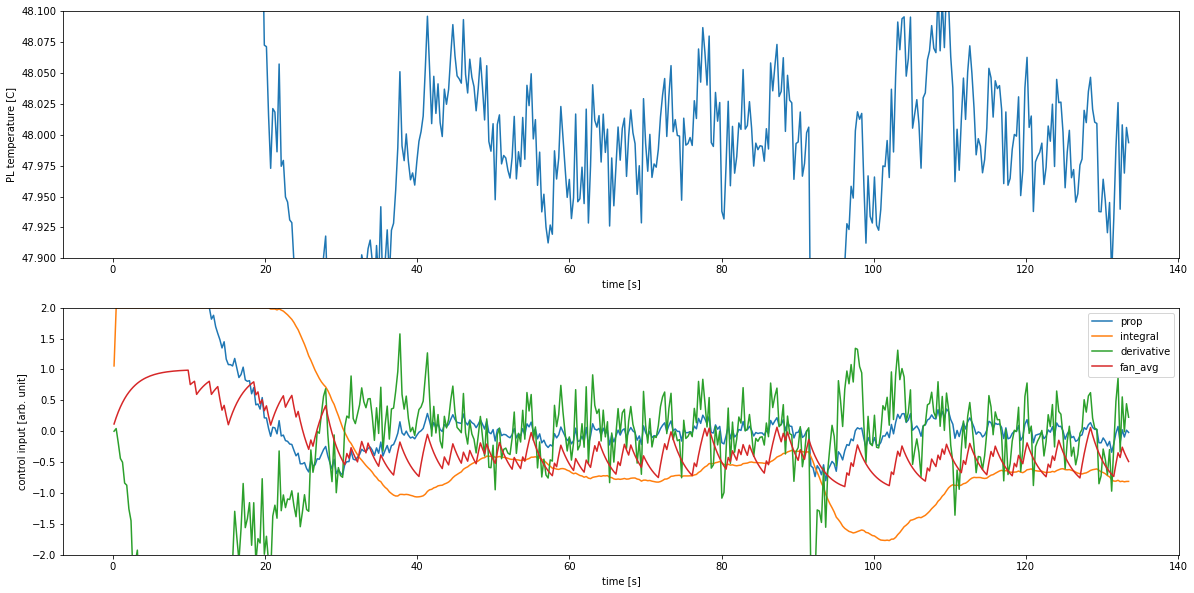

In [447]:
t = data[:,0]
fig, axes = plt.subplots(2, 1, figsize=(20,10))

plot = axes[0]
plot.plot(t, data[:,1], label='temperature')
plot.set_ylim((target-0.1, target+0.1))
plot.set_xlabel("time [s]")
plot.set_ylabel("PL temperature [C]")

plot = axes[1]
plot.set_xlabel("time [s]")
plot.set_ylabel("control input [arb. unit]")
plot.plot(t, data[:,2]*kp, label='prop')
plot.plot(t, data[:,3]*ki, label='integral')
plot.plot(t, data[:,4]*kd, label='derivative')
# plot.plot(t, data[:,5], label='control')
# plot.plot(t, data[:,6], label='fan')
plot.plot(t, data[:,7], label='fan_avg')

plot.set_ylim((-2, 2))
plot.legend();

### scratchwork below

(30.0, 60.0)

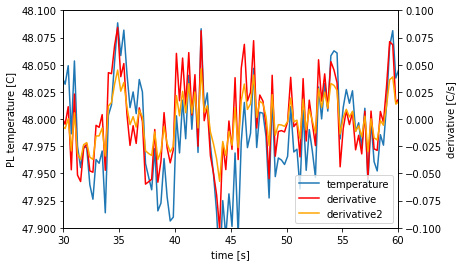

In [267]:
# look at different derivative filters
t = data[:,0]
vals = data[:,1]

t_deriv = 1.0 # time constant for derivative filter, smaller value speeds up updates but increases noise
filt_deriv = (1.0-np.exp(-dt/t_deriv))

prev = None
derivs = []
for x in vals:
    if prev is None:
        prev = x
        deriv = 0
    diff = (x-prev)/dt
    prev = x
    deriv += filt_deriv*(diff-deriv)
    derivs.append(deriv)

t_deriv = 2.0 # time constant for derivative filter, smaller value speeds up updates but increases noise
filt_deriv = (1.0-np.exp(-dt/t_deriv))

prev = None
derivs2 = []
for x in vals:
    if prev is None:
        prev = x
        deriv = 0
    diff = (x-prev)/dt
    prev = x
    deriv += filt_deriv*(diff-deriv)
    derivs2.append(deriv)
fig = plt.figure()

plt.plot(t, vals, label='temperature')
plot = fig.axes[0]
plot.set_ylim((target-2/kp, target+2/kp))
plot.set_xlabel("time [s]")
plot.set_ylabel("PL temperature [C]")

ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(t, derivs, color='red', label='derivative')
ax2.plot(t, derivs2, color='orange', label='derivative2')

ax2.set_ylabel("derivative [C/s]")
ax2.set_ylim((-5/kd, 5/kd))

# # combine the legends: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines, labels = plot.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2);
plt.xlim((30,60))

In [219]:
# compare RMS (with linear trend subtracted) for different sample spacing
while True:
    for i in range(3):
        t0 = time.time()
        data = np.array([get_channel_value(ch, 0.25, spacing=0) for i in range(100)])
        m, c = np.linalg.lstsq(np.vstack([np.arange(len(data)), np.ones(len(data))]).T, data, rcond=None)[0]
        print(time.time()-t0, np.std(data), np.std(data - m*np.arange(len(data))))
    for i in range(3):
        t0 = time.time()
        data = np.array([get_channel_value(ch, 0.25, spacing=0.001) for i in range(100)])
        m, c = np.linalg.lstsq(np.vstack([np.arange(len(data)), np.ones(len(data))]).T, data, rcond=None)[0]
        print(time.time()-t0, np.std(data), np.std(data - m*np.arange(len(data))))
    for i in range(3):
        t0 = time.time()
        data = np.array([get_channel_value(ch, 0.25, spacing=0.002) for i in range(100)])
        m, c = np.linalg.lstsq(np.vstack([np.arange(len(data)), np.ones(len(data))]).T, data, rcond=None)[0]
        print(time.time()-t0, np.std(data), np.std(data - m*np.arange(len(data))))
    for i in range(3):
        t0 = time.time()
        data = np.array([get_channel_value(ch, 0.25, spacing=0.005) for i in range(100)])
        m, c = np.linalg.lstsq(np.vstack([np.arange(len(data)), np.ones(len(data))]).T, data, rcond=None)[0]
        print(time.time()-t0, np.std(data), np.std(data - m*np.arange(len(data))))

24.712261199951172 0.038583205110208414 0.038170110446548576
24.798773050308228 0.056308755799025806 0.045998405331853676
24.834295749664307 0.03461695246153937 0.028278874782751023
25.80499577522278 0.05846897048922192 0.05842235588432075
25.805790901184082 0.04944918044097295 0.040091419735316644
25.8063223361969 0.08898693674434946 0.06910805151221845
28.79982352256775 0.20153145162608188 0.05752817632633288
28.799136877059937 0.33133592979161564 0.03751472926671625
28.797504901885986 0.2845007624562198 0.04355480957391893
26.94018030166626 0.2662397437681735 0.0353002166326985
26.9438693523407 0.13621458515719193 0.06098796441300644
26.943554639816284 0.14121267591905745 0.03935709121126565
24.735129594802856 0.061848354021354544 0.027248154822181733
24.814420223236084 0.11349291512796049 0.040569572637668846
24.89694333076477 0.05209694791221545 0.043735713072528055
25.818370819091797 0.06266344272723318 0.039673117334293434
25.797945022583008 0.05832448582766422 0.039592167064426

KeyboardInterrupt: 

In [306]:
# record for 100 seconds
t0 = time.time()
vals = np.array([int(ch.attrs['raw'].value) for i in range(1200000)])
print(time.time()-t0)

100.47453236579895


In [175]:
t_integral = 1.0 # time constant for integral filter

(1.0-np.exp(-dt/t_integral))

0.22119921692859512

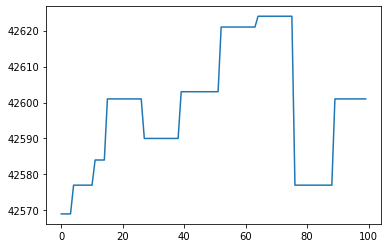

In [325]:
# the PL reading doesn't actually update at 12 kHz
plt.plot(vals[:100])

(0.1, 10000.0)

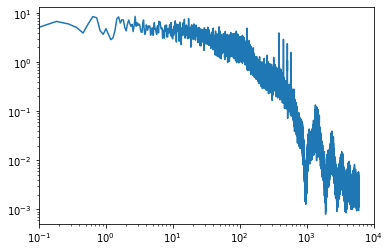

In [307]:
# plot the noise power spectrum
from scipy.signal import welch
freqs, psd = welch(vals, fs=SAMPS_PER_SEC, return_onesided=True, nperseg=2**17, detrend='linear')
plt.loglog(freqs, psd)
plt.xlim((0.1,1e4))
# plt.ylim((1e-1,1e1))

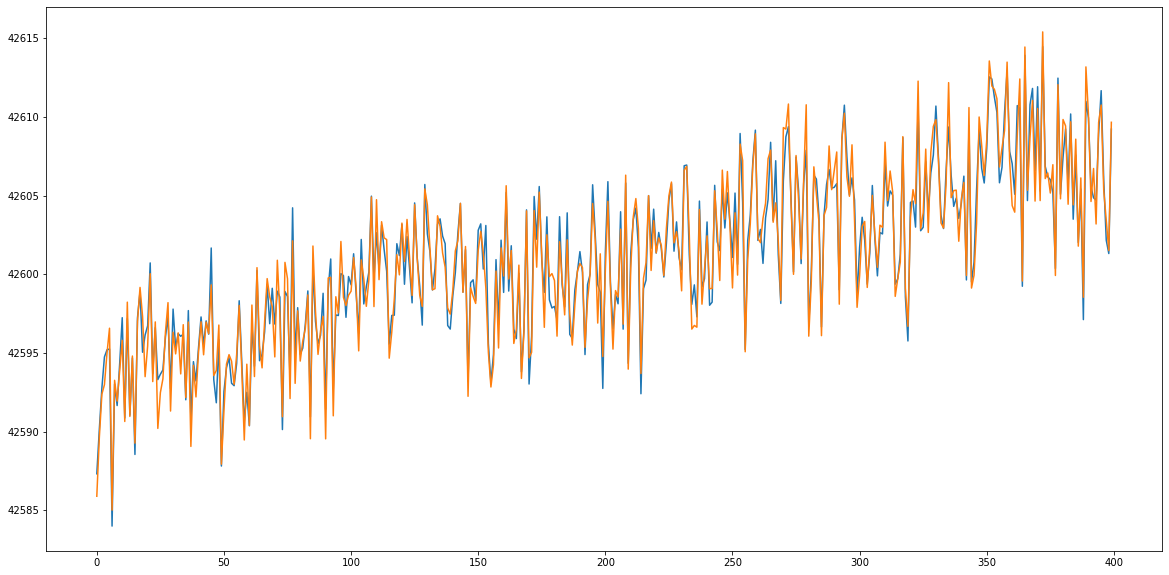

In [330]:
# compare different sampling intervals
fig = plt.figure(figsize=(20,10))

plt.plot(vals.reshape((-1,3000)).mean(axis=1))
# plt.plot(vals[::12].reshape((-1,250)).mean(axis=1))
plt.plot(vals[::24].reshape((-1,125)).mean(axis=1))
# plt.plot(vals[::60].reshape((-1,50)).mean(axis=1))


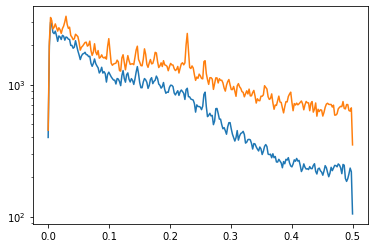

In [324]:
freqs, psd = welch(vals.reshape((-1, 24)).mean(axis=1), return_onesided=True, nperseg=512, detrend='linear')
plt.semilogy(freqs, psd)

freqs, psd = welch(vals[::24], return_onesided=True, nperseg=512, detrend='linear')
plt.semilogy(freqs, psd)

In [327]:
# compare the three temperature readings
# PS and remote temperature have a lot more white noise
c = iio.LocalContext()
d = c.find_device('ams')
chs = [d.find_channel(x) for x in ['pl_temp', 'ps_temp', 'remote_temp']]

data = []
t0 = time.time()
for i in range(12000//len(chs)):
    data.append([int(ch.attrs['raw'].value) for ch in chs])
# vals = [int(ch.attrs['raw'].value) for i in range(1200000)]
print(time.time()-t0)
data = np.array(data)

1.0124702453613281


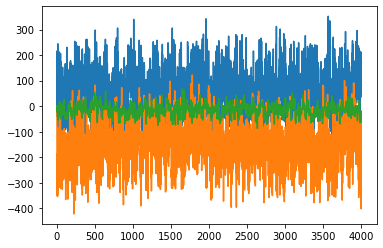

In [329]:
plt.plot(data[:,1]-data[0,1])
plt.plot(data[:,2]-data[0,2])
plt.plot(data[:,0]-data[0,0])


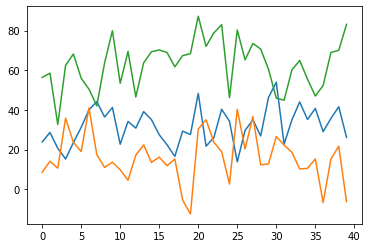

In [170]:
plt.plot(data[:,0].reshape((-1,100)).mean(axis=1)-data[0,0])
plt.plot(data[:,1].reshape((-1,100)).mean(axis=1)-data[0,1])
plt.plot(data[:,2].reshape((-1,100)).mean(axis=1)-data[0,2])

# plt.plot(data[:,2])

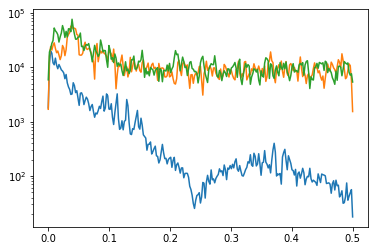

In [173]:
from scipy.signal import welch
freqs, psd = welch(data[:,0], return_onesided=True, nperseg=512, detrend='linear')
plt.semilogy(freqs, psd)
freqs, psd = welch(data[:,1], return_onesided=True, nperseg=512, detrend='linear')
plt.semilogy(freqs, psd)
freqs, psd = welch(data[:,2], return_onesided=True, nperseg=512, detrend='linear')
plt.semilogy(freqs, psd)
# np.fft.rfft(vals)

In [21]:
with gpiod.Chip("/dev/gpiochip2") as chip:
    
    line = chip.find_line("MAX6643_FULL_SPEED")
    line.request("")
    line.set_direction_output()
    print(line.direction())
    line.set_value(0)
    print(line.get_value())    

2
0


In [8]:
# list all the sysmon channels
for ch in d.channels:
    if 'offset' in ch.attrs:
        print(ch.name, (int(ch.attrs['raw'].value)+int(ch.attrs['offset'].value))*float(ch.attrs['scale'].value)/1000)
    else:
        print(ch.name, int(ch.attrs['raw'].value)*float(ch.attrs['scale'].value)/1000)

ps_temp 38.997461728055995
remote_temp 41.562061642416
pl_temp 41.03359862976
vcc_pspll0 1.200164790006
vcc_psbatt 1.742156975286
vccpsddr 1.195266718737
vccpsio3 1.796630852016
vccpsio0 1.79763793209
vccpsio1 1.796173088346
vccpsio2 1.794799797336
psmgtravcc 0.856201168368
psmgtravtt 1.80541991448
vccams 0.601287839334
vccint 0.8541870082199999
vccaux 1.804824821709
vccint 0.854736324624
vccvrefp 1.249832148201
vccvrefn 0.001281738276
vccbram 0.8588104212869999
vccplintlp 0.8581237757819999
vccplintfp 0.8562927211019999
vccplaux 1.807525627362
vccams 0.603164670381
vccbram 0.856567379304
vccaux 1.8034057543320001
vcc_psddrpll 1.804595939874
vccpsintfpddr 0.855651851964
vccpsintlp 0.855010982826
vccpsintfp 0.854736324624
vccpsaux 1.8042297289379998


In [95]:
# CLI interface
!iio_attr -c ams pl_temp

dev 'ams', channel 'temp2' (input), id 'pl_temp', attr 'label', value 'pl_temp'
dev 'ams', channel 'temp2' (input), id 'pl_temp', attr 'offset', value '-36058'
dev 'ams', channel 'temp2' (input), id 'pl_temp', attr 'raw', value '41788'
dev 'ams', channel 'temp2' (input), id 'pl_temp', attr 'scale', value '7.771514892'


In [ ]:
# pinning the integral at 0 at the beginning avoids overshoot at the cost of convergence speed
duration = 60 # seconds
target = 48.0 # C

data = []

dt = 0.25 # time to average over - seconds
t_deriv = 1.0 # time constant for derivative filter, smaller value speeds up updates but increases noise - seconds
t_integral = 60.0 # time constant for integral filter - seconds
t_fan = 2.0 # time constant for averaging the fan - seconds

# PID parameters, bigger = more aggressive
kp = 5 # 1/C
ki = 50 # 1/C
kd = 20 # s/C

filt_deriv = (1.0-np.exp(-dt/t_deriv))
filt_integral = (1.0-np.exp(-dt/t_integral))
filt_fan = (1.0-np.exp(-dt/t_fan))

prev = None
first_prop = None # we use this to hold integral at 0 until the first zero crossing

integral = 0
deriv = 0
fan = -1 # this is -1 for auto, +1 for full-speed
fan_avg = 0
with gpiod.Chip("/dev/gpiochip2") as chip:
    line = chip.find_line("MAX6643_FULL_SPEED")
    line.request("blah")
    line.set_direction_output()
    for i in tqdm(range(int(duration/dt))):
        val = get_channel_value(ch, dt)
        
        prop = val-target
        if prev is None:
            prev = prop
        diff = (prop-prev)/dt
        prev = prop
        deriv += filt_deriv*(diff-deriv)
        integral += filt_integral*(prop-integral)
        
        if first_prop is None:
            integral = 0
            if prop != 0:
                first_prop = prop
        elif prop*first_prop > 0:
            integral = 0
        else:
            first_prop = 0
        
        control = prop*kp + integral*ki + deriv*kd
        if control > fan_avg:
            fan = 1
            line.set_value(1) # fan at full speed
        elif control < fan_avg:
            fan = -1
            line.set_value(0) # fan at auto
        fan_avg += filt_fan*(fan-fan_avg)

        data.append((time.time(), val, prop, integral, deriv, control, fan, fan_avg))
            
    line.set_value(0) # put fan back on auto when we're done
    
data = np.array(data)
data[:,0] -= data[0,0] # times are relative to start